# Building Data Genome Project 2.0
## Exploratory data analysis of weather

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.dpi'] = 80
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import gc

# Datasets

<p><b>Meter readings</b></p>
<ul>
<li><code>timestamp</code>: date and time in the format YYYY-MM-DD hh:mm:ss. 2016 and 2017 data.</li>
<li><code>building_id</code>: building code-name with the structure <i>UniqueFirstName_SiteID_primaryspaceusage</i>.</li>
<li><code>meter_reading</code>: meter reading in kilowatt hour (kWh) .</li>
<li><code>meter</code>: meter type, <code>chilledwater</code>, <code>electricity</code>, <code>gas</code>, <code>hotwater</code>, <code>irrigation</code>, <code>solar</code>, <code>steam</code> or <code>water</code>.</li>
</ul>

In [75]:
path_meters = "..\\data\\meters\\processed\\"
path_meta = "..\\data\\metadata\\"
path_weather = "..\\data\\weather\\"

In [33]:
# Buildings data
metadata = pd.read_csv(path_meta + "metadata.csv")
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 30 columns):
building_id              1636 non-null object
site_id                  1636 non-null object
primaryspaceusage        1615 non-null object
sqft                     1636 non-null float64
lat                      1636 non-null float64
lng                      1636 non-null float64
electricity              1578 non-null object
hotwater                 185 non-null object
chilledwater             555 non-null object
steam                    370 non-null object
water                    146 non-null object
irrigation               37 non-null object
solar                    5 non-null object
gas                      177 non-null object
yearbuilt                817 non-null float64
numberoffloors           441 non-null float64
sub_primaryspaceusage    1615 non-null object
date_opened              21 non-null object
energystarscore          163 non-null object
eui                      299 

In [3]:
# Meters reading data
meters = pd.read_csv(path_meters + "allmeters.csv")
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53561832 entries, 0 to 53561831
Data columns (total 4 columns):
timestamp        object
building_id      object
meter_reading    float64
meter            object
dtypes: float64(1), object(3)
memory usage: 1.6+ GB


## Reducing memory size

In [4]:
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# Reduce memory
#metadata = reduce_mem_usage(metadata)
meters = reduce_mem_usage(meters)
gc.collect()

Mem. usage decreased to 1430.26 Mb (12.5% reduction)


74

In [34]:
# Features from buildings metadata to add to meters dataset
buildings_sel = metadata[["building_id","site_id","primaryspaceusage","timezone"]]

In [35]:
# Join the datasets: meter reading + building metadata
dev = meters.merge(buildings_sel, on="building_id", how = "left")
# Transform timestamp to datetime object type
dev["timestamp"] = pd.to_datetime(dev["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [12]:
# Transform timestamp to datetime object type
meters["timestamp"] = pd.to_datetime(meters["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [37]:
del(metadata,buildings_sel)
gc.collect()

4457

# Exploratory Data Analysis

## Target variable: <code>meter_reading</code>

Energy consumption in kWh (or equivalent).

### Distribution

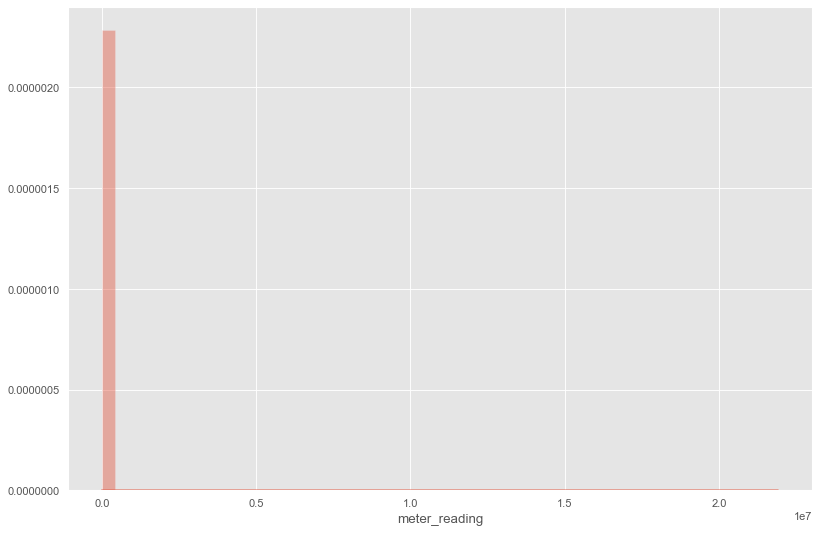

In [19]:
sns.distplot(meters["meter_reading"].dropna())

The distribution is highly skewed, there are a lot of low (or zero) values, as seen in previous section. Logarithmic transformation is applied; to avoid zero values error, sums 1.

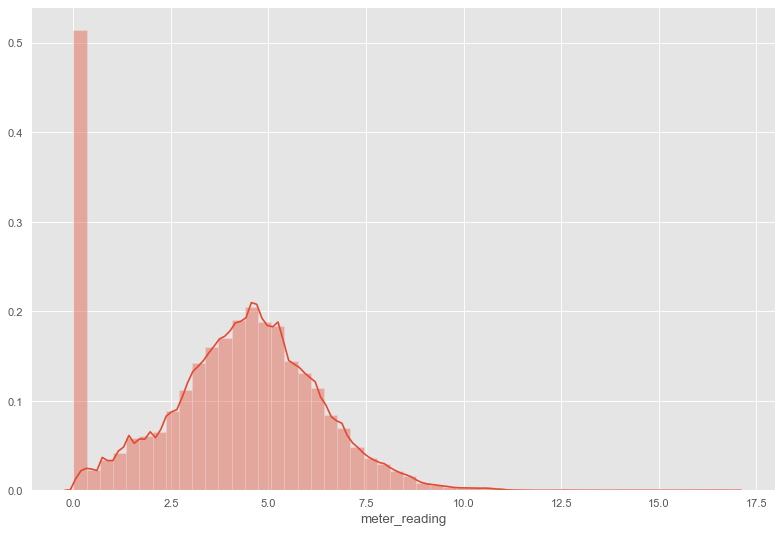

In [20]:
# Log transformation. Sums +1 for the meter_reading = 0
sns.distplot(np.log(meters["meter_reading"].dropna()+1))

Similar as before, but instead of summing 1 zero values are left out.

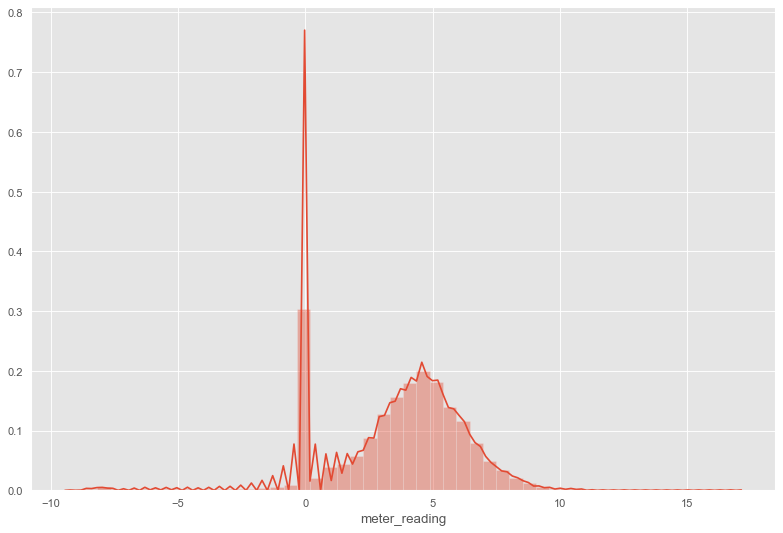

In [21]:
# Same as before, but avoiding zero values
sns.distplot(np.log(meters["meter_reading"].dropna(), where=(dev["meter_reading"].dropna()!=0)))

### Distribution by <code>meter</code>

In [6]:
# Color palette
colors =  ["rebeccapurple", "crimson", "orangered", "gold", "olivedrab", "royalblue", "darkcyan", "dimgrey"]

[Text(0, 0.5, ''), Text(0.5, 0, 'Meter reading')]

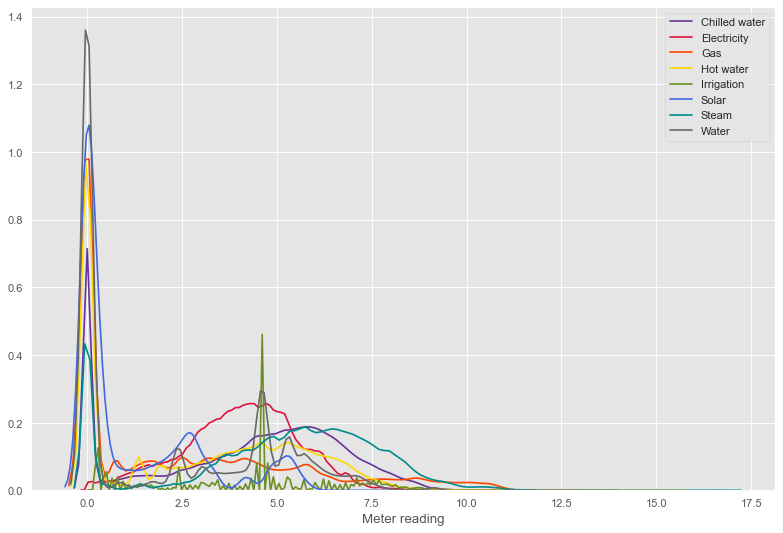

In [10]:
f, axes = plt.subplots(1, 1)

m1 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="chilledwater", "meter_reading"]+1), hist=False, label="Chilled water", color = colors[0], ax=axes)
m2 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="electricity", "meter_reading"]+1), hist=False, label="Electricity", color = colors[1], ax=axes)
m3 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="gas", "meter_reading"]+1), hist=False, label="Gas", color = colors[2], ax=axes)
m4 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="hotwater", "meter_reading"]+1), hist=False, label="Hot water", color = colors[3], ax=axes)
m5 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="irrigation", "meter_reading"]+1), hist=False, label="Irrigation", color = colors[4], ax=axes)
m6 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="solar", "meter_reading"]+1), hist=False, label="Solar", color = colors[5], ax=axes)
m7 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="steam", "meter_reading"]+1), hist=False, label="Steam", color = colors[6], ax=axes)
m8 = sns.distplot(np.log(meters.dropna().loc[meters["meter"]=="water", "meter_reading"]+1), hist=False, label="Water", color = colors[7], ax=axes)

axes.set(ylabel="", xlabel="Meter reading")

In [11]:
f.savefig("..\\figures\\meters_hist.pdf", bbox_inches='tight')
f.savefig("..\\figures\\meters_hist.png", dpi=72, bbox_inches='tight')

### Behaviour by month

The data has a skewed distribution, median instead of mean will be used.

In [14]:
# datetime indexes
times = pd.DatetimeIndex(meters.timestamp)

#### Month

Text(0.5, 0.98, 'Meter reading by month')

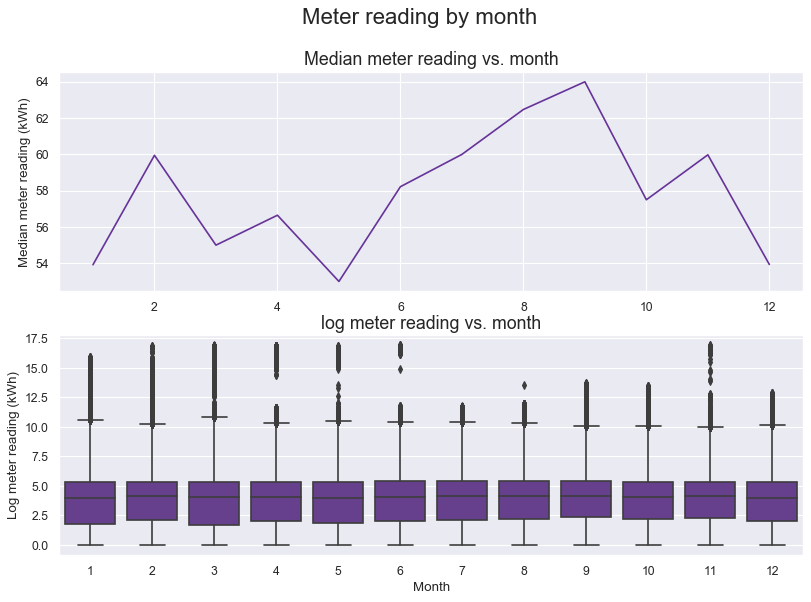

In [36]:
# Median for each month (12)
sns.set(rc={'figure.figsize':(12,8)})
#sns.set(font_scale = 2)
f, axes = plt.subplots(2, 1, sharex=False)
axes = axes.flatten()

# Creates a temporal dataframe grouped by month
temp = pd.DataFrame(meters.groupby([times.month]).median()["meter_reading"]).reset_index()
# lineplot
ax1 = axes[0]
sns.lineplot(data=temp, x="timestamp", y="meter_reading", ax=ax1, color=colors[0])
ax1.set_ylabel("Median meter reading (kWh)")
ax1.set_xlabel("")
ax1.set_title('Median meter reading vs. month', fontdict={'size':16})

# Creates a temporal dataframe
temp = pd.DataFrame({"month":meters.timestamp.dt.month, "meter_reading": np.log(meters.meter_reading+1)})
# boxplot
ax2 = axes[1]
sns.boxplot(data=temp, x="month", y="meter_reading", ax=ax2, color=colors[0])
ax2.set_ylabel("Log meter reading (kWh)")
ax2.set_xlabel("Month")
ax2.set_title('log meter reading vs. month', fontdict={'size':16})

f.suptitle('Meter reading by month', fontsize=20)
#f.tight_layout()

In [38]:
f.savefig("..\\figures\\meters_month.pdf", bbox_inches='tight')
f.savefig("..\\figures\\meters_month.png", dpi=72, bbox_inches='tight')

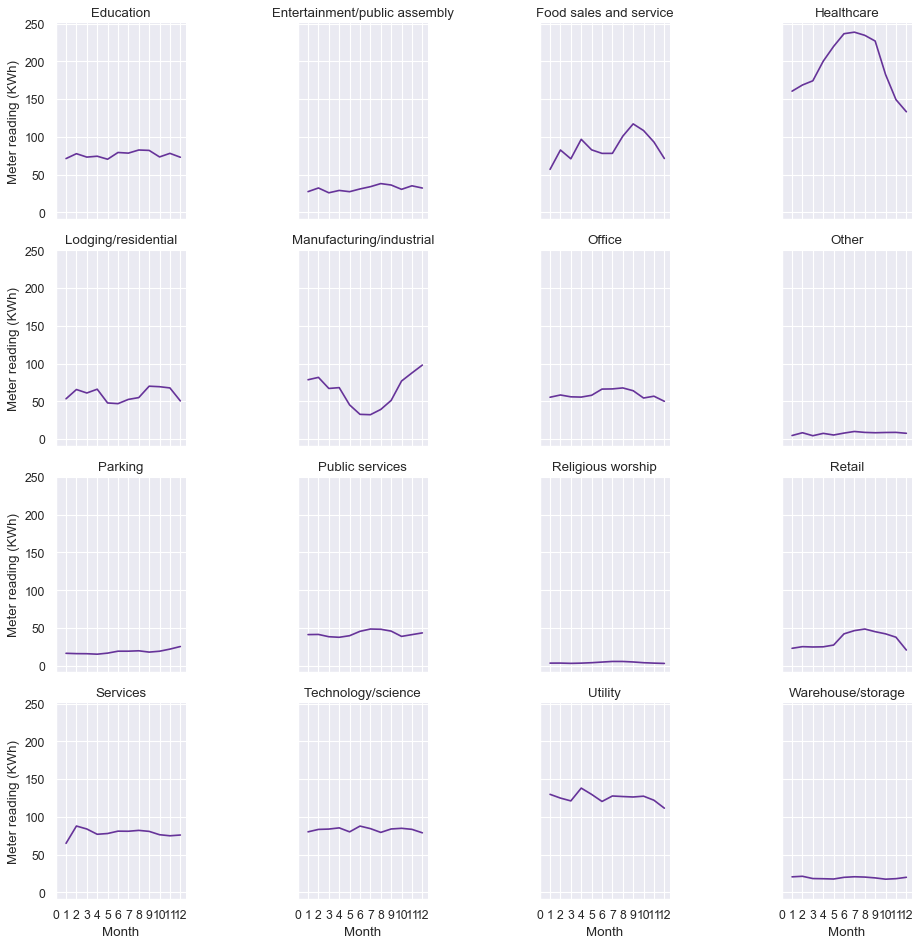

In [60]:
# Creates a temporal dataframe grouped by primaryspaceusage (16) and month (12)
temp = pd.DataFrame(dev.groupby(["primaryspaceusage", times.month]).median()["meter_reading"]).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="primaryspaceusage", col_wrap=4)
g.map(plt.plot, "timestamp", "meter_reading", color=colors[0])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Month", y_var="Meter reading (KWh)")
g.set(xticks=range(13))

In [61]:
g.savefig("..\\figures\\meters_month_usage.pdf", bbox_inches='tight')
g.savefig("..\\figures\\meters_month_usage.png", dpi=72, bbox_inches='tight')

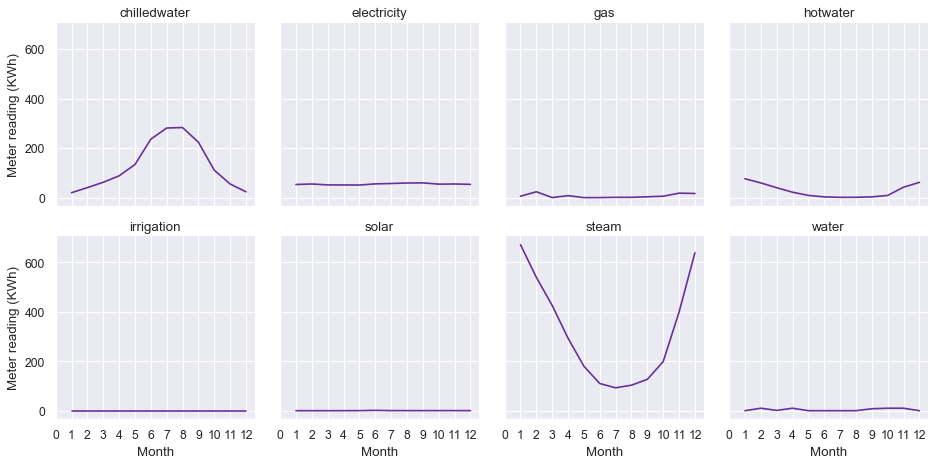

In [62]:
# Creates a temporal dataframe grouped by meter (8) and month (12)
temp = pd.DataFrame(dev.groupby(["meter", times.month]).median()["meter_reading"]).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="meter", col_wrap=4)
g.map(plt.plot, "timestamp", "meter_reading", color=colors[0])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Month", y_var="Meter reading (KWh)")
g.set(xticks=range(13))

In [63]:
g.savefig("..\\figures\\meters_month_metertype.pdf", bbox_inches='tight')
g.savefig("..\\figures\\meters_month_metertype.png", dpi=72, bbox_inches='tight')

### Behaviour by hour of the day

Text(0.5, 0.98, 'Meter reading by hour')

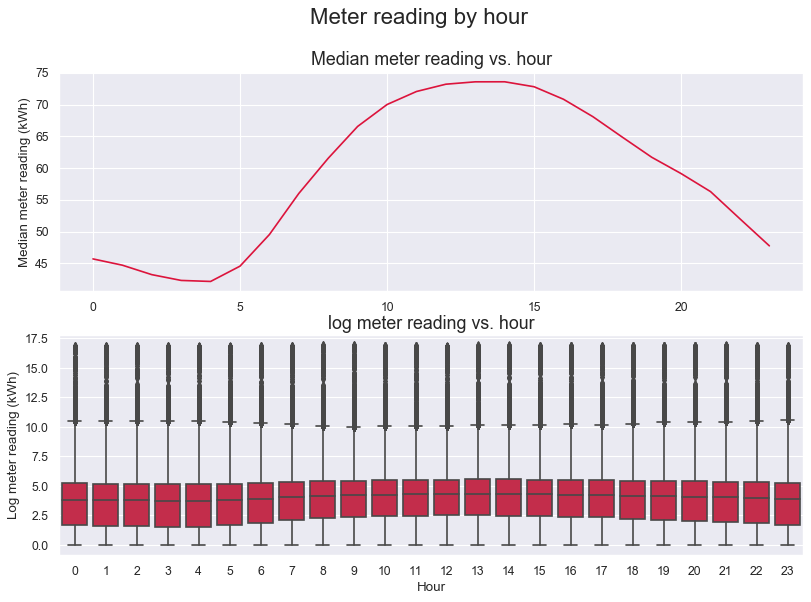

In [39]:
# median by dayhour (24)
# Median for each day hour
sns.set(rc={'figure.figsize':(12,8)})
#sns.set(font_scale = 1.5)
f, axes = plt.subplots(2, 1, sharex=False)
axes = axes.flatten()

# Creates a temporal dataframe grouped by day hour (24)
temp = pd.DataFrame(meters.groupby([times.hour]).median()["meter_reading"]).reset_index()
# lineplot
ax1 = axes[0]
sns.lineplot(data=temp, x="timestamp", y="meter_reading", ax = ax1, color=colors[1])
ax1.set_ylabel("Median meter reading (kWh)")
ax1.set_xlabel("")
ax1.set_title('Median meter reading vs. hour', fontdict={'size':16})

# Creates a temporal dataframe
temp = pd.DataFrame({"hour":meters.timestamp.dt.hour, "meter_reading": np.log(meters.meter_reading+1)})
# boxplot
ax2 = axes[1]
sns.boxplot(data=temp, x="hour", y="meter_reading", ax=ax2, color=colors[1])
ax2.set_ylabel("Log meter reading (kWh)")
ax2.set_xlabel("Hour")
ax2.set_title('log meter reading vs. hour', fontdict={'size':16})

f.suptitle('Meter reading by hour', fontsize=20)
#f.tight_layout()

In [40]:
f.savefig("..\\figures\\meters_hour.pdf", bbox_inches='tight')
f.savefig("..\\figures\\meters_hour.png", dpi=72, bbox_inches='tight')

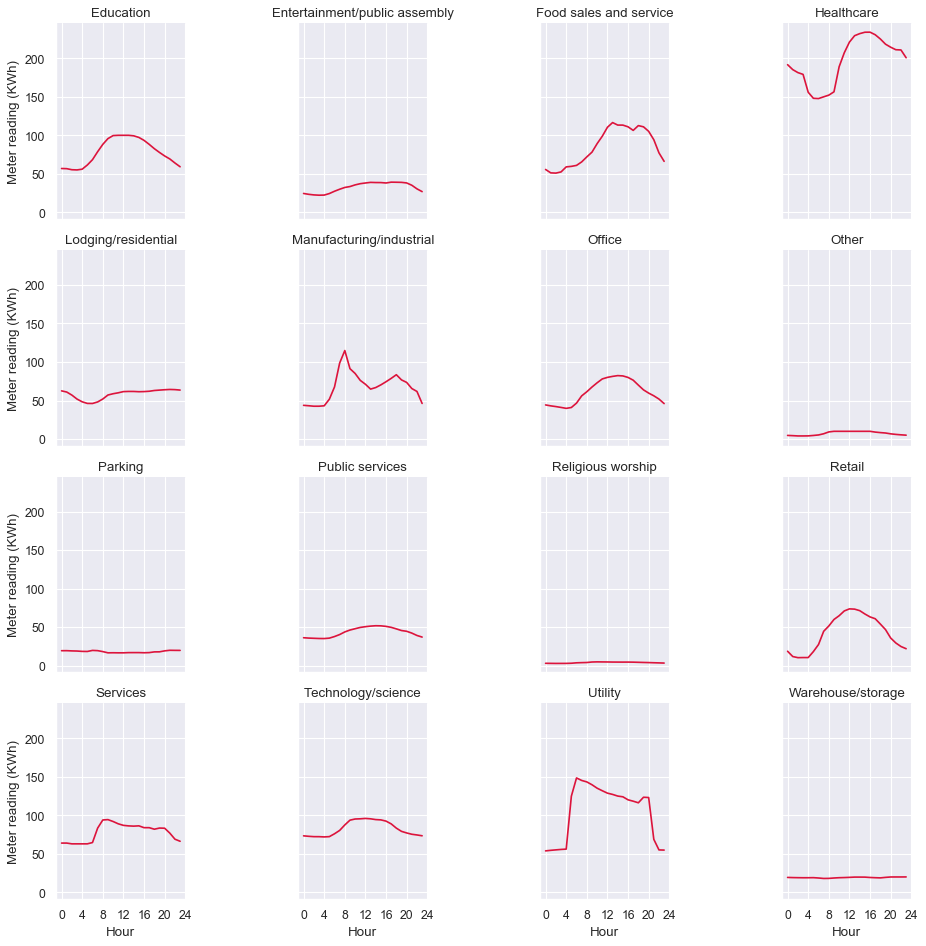

In [64]:
# Creates a temporal dataframe grouped by primaryspaceusage and day hour
temp = pd.DataFrame(dev.groupby(["primaryspaceusage", times.hour]).median()["meter_reading"]).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="primaryspaceusage", col_wrap=4)
g.map(plt.plot, "timestamp", "meter_reading", color=colors[1])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Hour", y_var="Meter reading (KWh)")
g.set(xticks=[0,4,8,12,16,20,24])

In [65]:
g.savefig("..\\figures\\meters_hour_usage.pdf", bbox_inches='tight')
g.savefig("..\\figures\\meters_hour_usage.png", dpi=72, bbox_inches='tight')

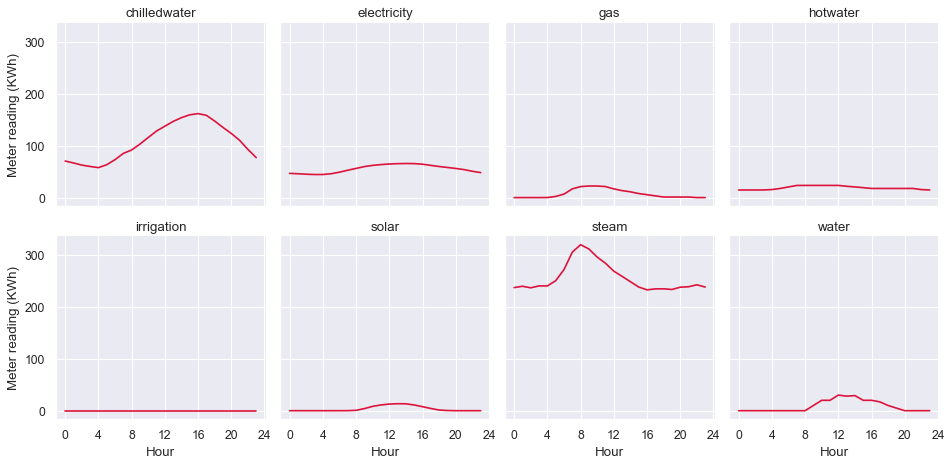

In [66]:
# Creates a temporal dataframe grouped by meter (8) and day hour (24)
temp = pd.DataFrame(dev.groupby(["meter", times.hour]).median()["meter_reading"]).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="meter", col_wrap=4)
g.map(plt.plot, "timestamp", "meter_reading", color=colors[1])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Hour", y_var="Meter reading (KWh)")
g.set(xticks=[0,4,8,12,16,20,24])

In [67]:
g.savefig("..\\figures\\meters_hour_metertype.pdf", bbox_inches='tight')
g.savefig("..\\figures\\meters_hour_metertype.png", dpi=72, bbox_inches='tight')

### Behaviour by day of the week

Text(0.5, 0.98, 'Meter reading by day of t he week')

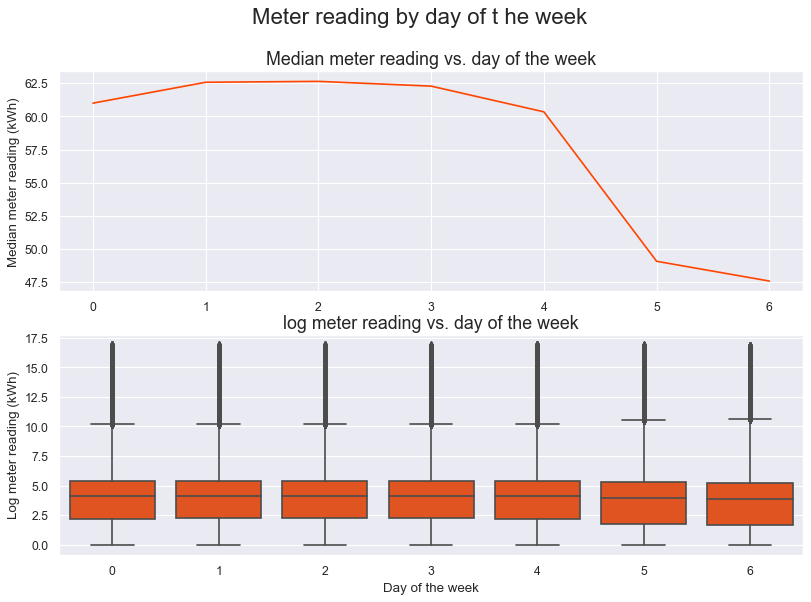

In [41]:
# median by weekday (7)
sns.set(rc={'figure.figsize':(12,8)})
#sns.set(font_scale = 2)
f, axes = plt.subplots(2, 1, sharex=False)
axes = axes.flatten()

# Creates a temporal dataframe grouped by day of the week (7)
temp = pd.DataFrame(meters.groupby([times.weekday]).median()["meter_reading"]).reset_index()
# lineplot
ax1 = axes[0]
sns.lineplot(data=temp, x="timestamp", y="meter_reading", ax=ax1, color=colors[2])
ax1.set_ylabel("Median meter reading (kWh)")
ax1.set_xlabel("")
ax1.set_title('Median meter reading vs. day of the week', fontdict={'size':16})

# Creates a temporal dataframe
temp = pd.DataFrame({"weekday":meters.timestamp.dt.weekday, "meter_reading": np.log(meters.meter_reading+1)})
# boxplot
ax2 = axes[1]
sns.boxplot(data=temp, x="weekday", y="meter_reading", ax=ax2, color=colors[2])
ax2.set_ylabel("Log meter reading (kWh)")
ax2.set_xlabel("Day of the week")
ax2.set_title('log meter reading vs. day of the week', fontdict={'size':16})

f.suptitle('Meter reading by day of t he week', fontsize=20)
#f.tight_layout()

In [42]:
f.savefig("..\\figures\\meters_weekday.pdf", bbox_inches='tight')
f.savefig("..\\figures\\meters_weekday.png", dpi=72, bbox_inches='tight')

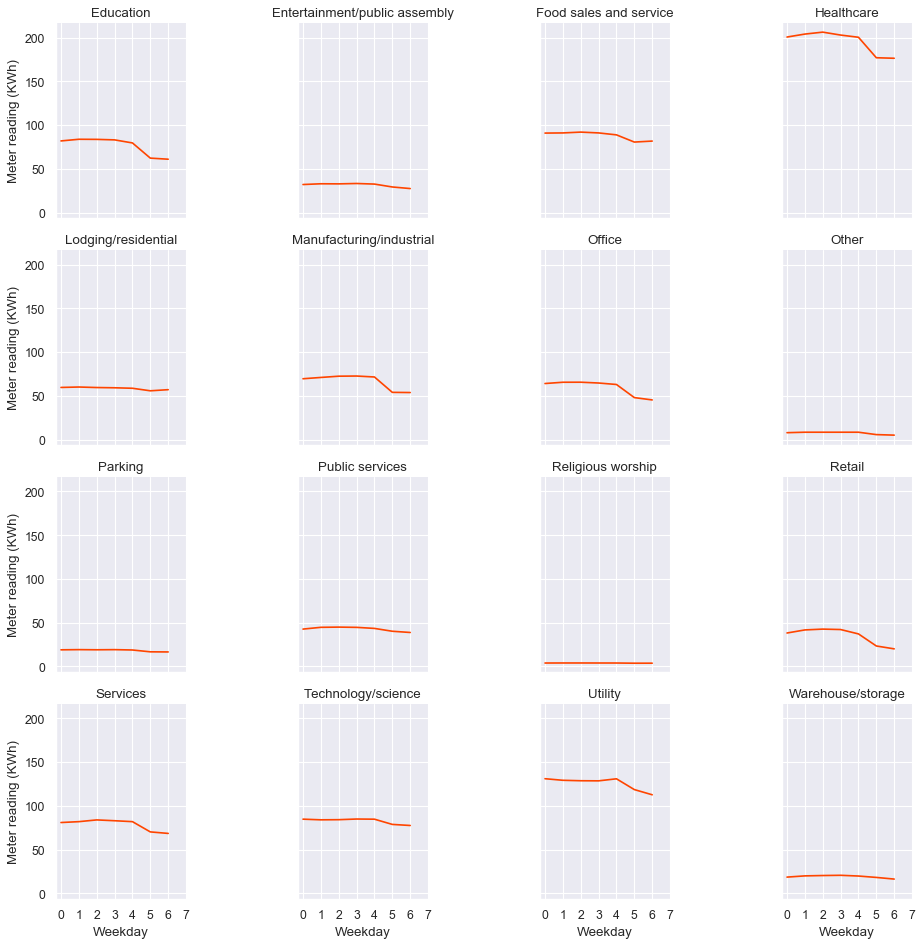

In [69]:
# Creates a temporal dataframe grouped by primaryspaceusage (16) and weekday (7)
temp = pd.DataFrame(dev.groupby(["primaryspaceusage", times.weekday]).median()["meter_reading"]).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="primaryspaceusage", col_wrap=4)
g.map(plt.plot, "timestamp", "meter_reading", color=colors[2])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Weekday", y_var="Meter reading (KWh)")
g.set(xticks=range(8))

In [70]:
g.savefig("..\\figures\\meters_weekday_usage.pdf", bbox_inches='tight')
g.savefig("..\\figures\\meters_weekday_usage.png", dpi=72, bbox_inches='tight')

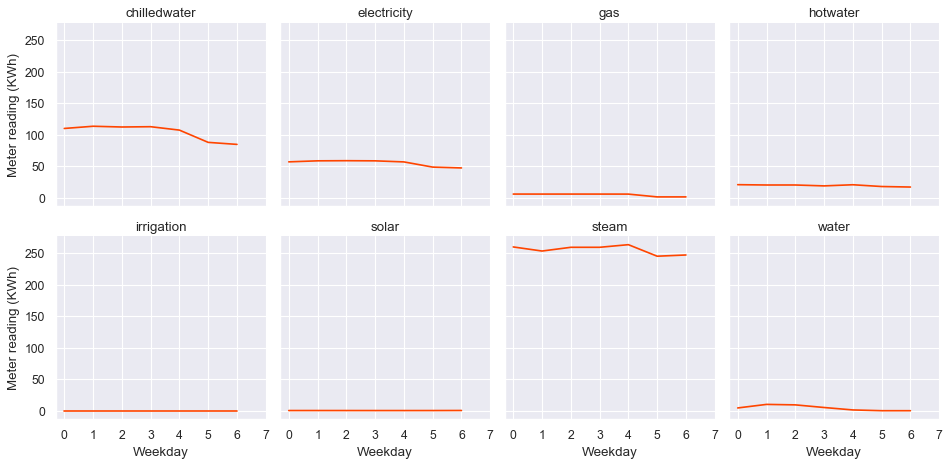

In [71]:
# Creates a temporal dataframe grouped by meter and day weekday
temp = pd.DataFrame(dev.groupby(["meter", times.weekday]).median()["meter_reading"]).reset_index()
# All the plots in a grid
g = sns.FacetGrid(temp, col="meter", col_wrap=4)
g.map(plt.plot, "timestamp", "meter_reading", color=colors[2])
# Title of each plot
g.set_titles("{col_name}")
# Axis labels
g.set_axis_labels(x_var="Weekday", y_var="Meter reading (KWh)")
g.set(xticks=range(8))

In [72]:
g.savefig("..\\figures\\meters_weekday_metertype.pdf", bbox_inches='tight')
g.savefig("..\\figures\\meters_weekday_metertype.png", dpi=72, bbox_inches='tight')

## Correlation

In [76]:
# Weather data
weather = pd.read_csv(path_weather + "weather.csv")
weather = reduce_mem_usage(weather)
weather.info()

Mem. usage decreased to 17.80 Mb (56.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333288 entries, 0 to 333287
Data columns (total 16 columns):
timestamp              333288 non-null object
site_id                333288 non-null object
apparentTemperature    333288 non-null float16
cloudCover             332221 non-null float16
dewPoint               333288 non-null float16
humidity               333288 non-null float16
precipIntensity        333286 non-null float16
precipType             42373 non-null object
pressure               330764 non-null float16
summary                333288 non-null object
temperature            333288 non-null float16
uvIndex                333065 non-null float16
visibility             332810 non-null float16
windBearing            322341 non-null float16
windGust               332657 non-null float16
windSpeed              333288 non-null float16
dtypes: float16(12), object(4)
memory usage: 17.8+ MB


In [79]:
# Transform timestamp to datetime object type
weather["timestamp"] = pd.to_datetime(weather["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [80]:
# Join the three datasets: meter reading + building metadata + weather info
dev = pd.merge(dev, weather,  how='left', left_on=['timestamp','site_id'], right_on = ['timestamp','site_id'])

In [86]:
# Drop categorical features
dev = dev.drop(["timestamp","building_id","meter","site_id","precipType","summary"], axis=1)
gc.collect()

28

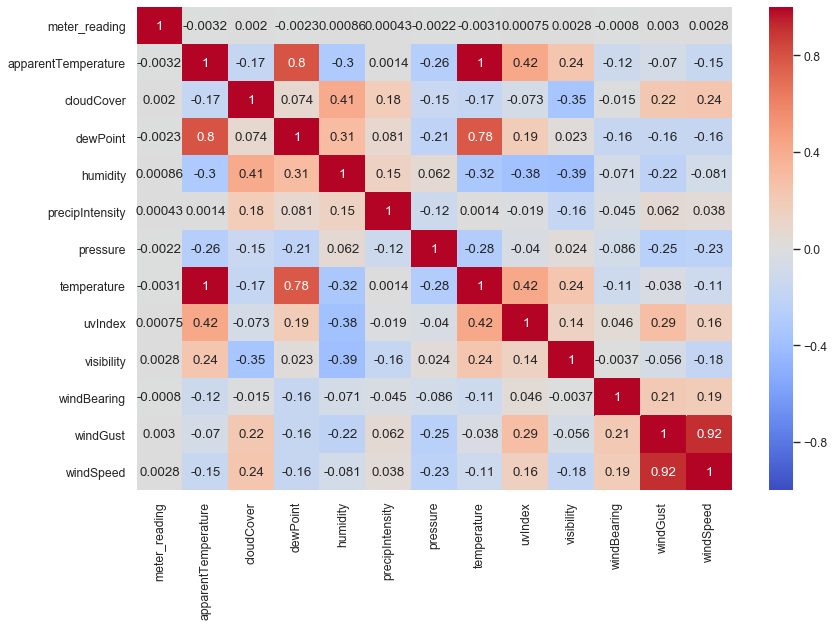

In [89]:
g = sns.heatmap(dev.corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True)